# QARTOD QC Demo

In [3]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import xarray as xa

from ioos_qc import qartod
from ioos_qc.streams import PandasStream
from ioos_qc.stores import PandasStore
from ioos_qc.config import Config
from ioos_qc.results import collect_results

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-v0_8-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [2]:
server_url = 'http://ecofoci-field.pmel.noaa.gov:8082/erddap'
dataset_name = 'datasets_Mooring_24bs2c_preliminary'
e = ERDDAP(server=server_url,
          protocol='tabledap',
          response='csv')

e.dataset_id=dataset_name

pdf = e.to_pandas(
            index_col='time (UTC)',
            parse_dates=True,
            skiprows=(1,)  # units information can be dropped.
        )
pdf.columns = [x.split()[0] for x in pdf.columns]

In [4]:
pdf

,depth,latitude,longitude,temperature,pressure,salinity,conductivity,chlorophyll_fluorescence,par,timeseries_id
time (UTC),,,,,,,,,,
2024-09-05 01:00:00+00:00,23.0,56.860207,-164.05528,8.6437,NaN,0.0195,0.002642,NaN,0.000118,24bs2c_s16_0023m
2024-09-05 02:00:00+00:00,23.0,56.860207,-164.05528,8.5358,NaN,0.0162,0.002126,NaN,0.000097,24bs2c_s16_0023m
2024-09-05 03:00:00+00:00,23.0,56.860207,-164.05528,8.4828,NaN,0.0158,0.002060,NaN,0.000097,24bs2c_s16_0023m
2024-09-05 04:00:00+00:00,23.0,56.860207,-164.05528,8.3206,NaN,0.0150,0.001936,NaN,0.000053,24bs2c_s16_0023m
2024-09-05 05:00:00+00:00,23.0,56.860207,-164.05528,8.0635,NaN,0.0149,0.001928,NaN,0.000053,24bs2c_s16_0023m
...,...,...,...,...,...,...,...,...,...,...
2025-05-03 15:00:00+00:00,45.0,56.860207,-164.05528,NaN,NaN,NaN,NaN,0.0684,NaN,24bs2c_eco_0045m
2025-05-03 16:00:00+00:00,45.0,56.860207,-164.05528,NaN,NaN,NaN,NaN,0.0684,NaN,24bs2c_eco_0045m
2025-05-03 17:00:00+00:00,45.0,56.860207,-164.05528,NaN,NaN,NaN,NaN,0.0684,NaN,24bs2c_eco_0045m


In [5]:
qc_config = {
    'pressure': {
        'qartod': {
          "gross_range_test": {
            "fail_span": [0,1000],
            "suspect_span": [0,750]
          },
          # "flat_line_test": { #not valid for bottom data
          #   "tolerance": 0.001,
          #   "suspect_threshold": 10800,
          #   "fail_threshold": 21600
          # },
          "rate_of_change_test": {
            "threshold": 0.5
          },
          "spike_test": {
            "suspect_threshold": 2,
            "fail_threshold": 4
          },
          "aggregate": {}
        }
    },
    'salinity': {
        'qartod': {
          "gross_range_test": {
            "fail_span": [20,40],
            "suspect_span": [25,35]
          },
          # "flat_line_test": { #not valid for bottom data
          #   "tolerance": 0.001,
          #   "suspect_threshold": 10800,
          #   "fail_threshold": 21600
          # },
          "rate_of_change_test": {
            "threshold": 0.1
          },
          "spike_test": {
            "suspect_threshold": 5,
            "fail_threshold": 10
          },
          "aggregate": {}
        }
    },
    'temperature': {
        'qartod': {
          "gross_range_test": {
            "fail_span": [-2,25],
            "suspect_span": [-2,15]
          },
          # "flat_line_test": { #not valid for bottom data
          #   "tolerance": 0.001,
          #   "suspect_threshold": 10800,
          #   "fail_threshold": 21600
          # },
          "rate_of_change_test": {
            "threshold": 0.1
          },
          "spike_test": {
            "suspect_threshold": 1.0,
            "fail_threshold": 3
          },
          "aggregate": {}
        }
    }
}
c = Config(qc_config)

In [7]:
# Setup the stream
ps = PandasStream(pdf.reset_index(), time='time (UTC)', lat='latitude', lon='longitude', z='depth"')

# Run the tests by passing in a Config object
results = ps.run(c)

store = PandasStore(results)

Could not run "qartod.aggregate: aggregate() missing 1 required positional argument: 'results'
Could not run "qartod.aggregate: aggregate() missing 1 required positional argument: 'results'
Could not run "qartod.aggregate: aggregate() missing 1 required positional argument: 'results'


In [9]:
# Compute any aggregations
store.compute_aggregate(name='rollup_qc')  # Appends to the results internally

# Write only the test results to the store
results_store = store.save(write_data=False, write_axes=False)

# Append columns from qc results back into the data - stick to simple case of aggregate only for now
results_store = pd.concat([pdf.reset_index(), 
                           results_store], axis=1)

Found duplicate QC results column: qartod_rollup_qc, skipping.


In [10]:
## keep 1,2 for each parameter and address parameters/test independently
orig_results_store = results_store.copy()
for keys in results_store.keys():
    if 'qartod' in keys:
        print(keys)
        results_store.loc[(results_store[keys] != 1) & (results_store[keys] != 2) & (results_store[keys] != 3),keys.split('_qartod')[0]] = np.nan
results_store = results_store.loc[:, ~results_store.columns.str.contains('qartod')]

pressure_qartod_gross_range_test
pressure_qartod_rate_of_change_test
pressure_qartod_spike_test
salinity_qartod_gross_range_test
salinity_qartod_rate_of_change_test
salinity_qartod_spike_test
temperature_qartod_gross_range_test
temperature_qartod_rate_of_change_test
temperature_qartod_spike_test
qartod_rollup_qc


time (UTC)
depth
latitude
longitude
temperature
pressure
salinity
conductivity
chlorophyll_fluorescence
par
timeseries_id


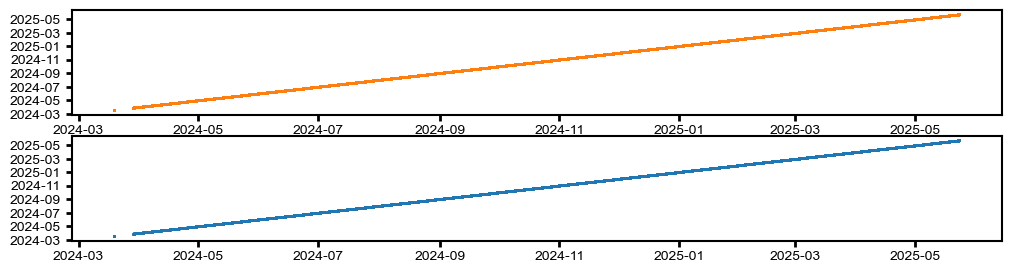

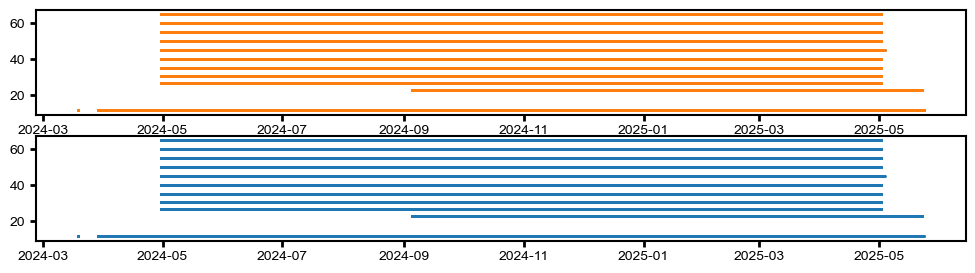

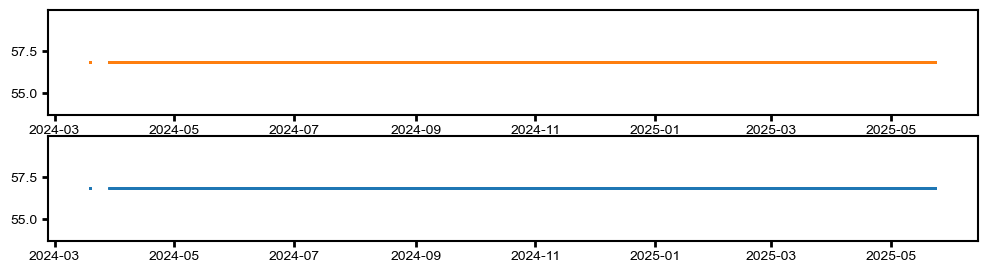

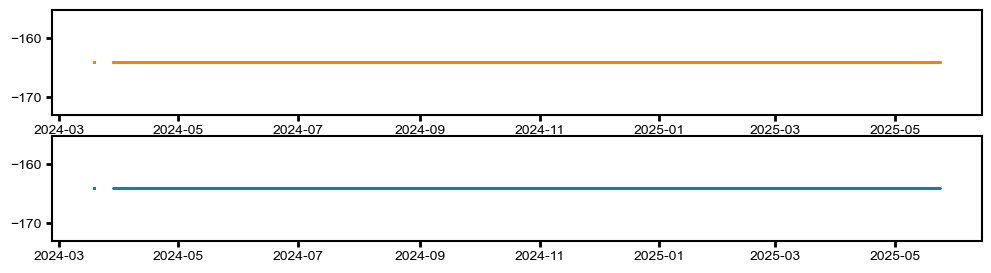

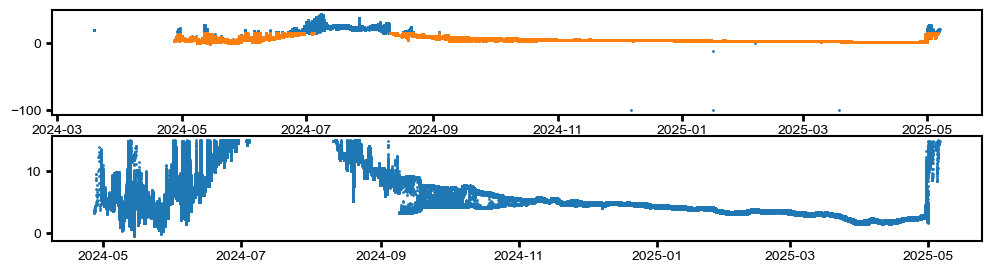

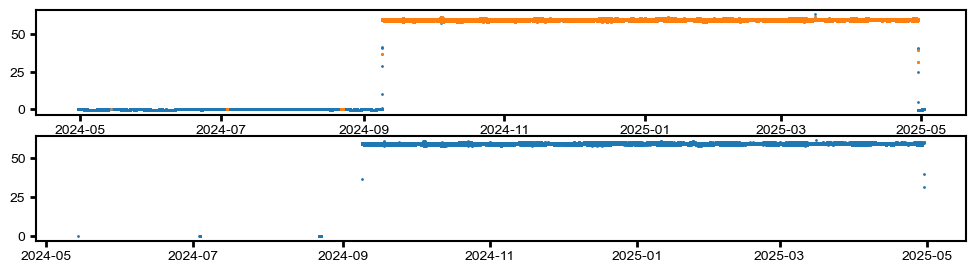

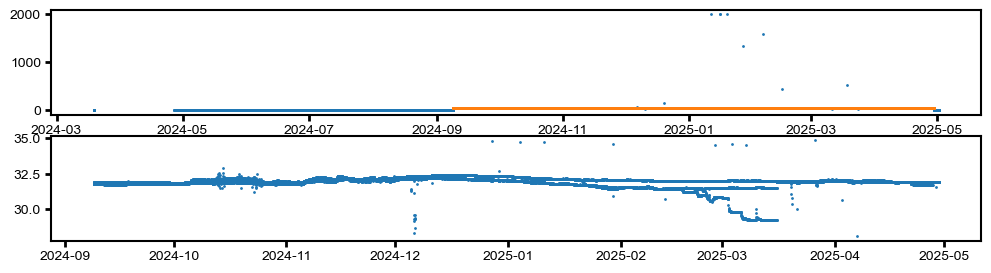

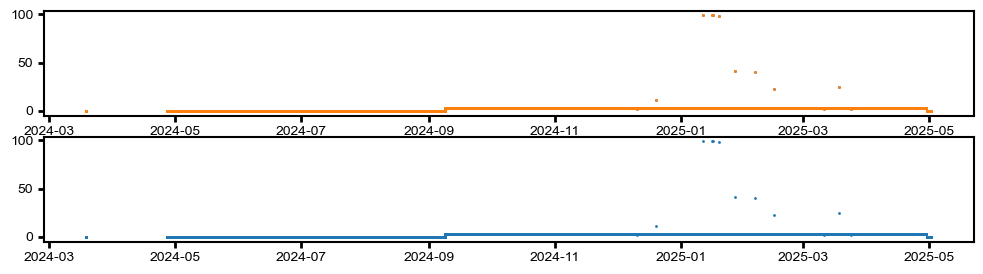

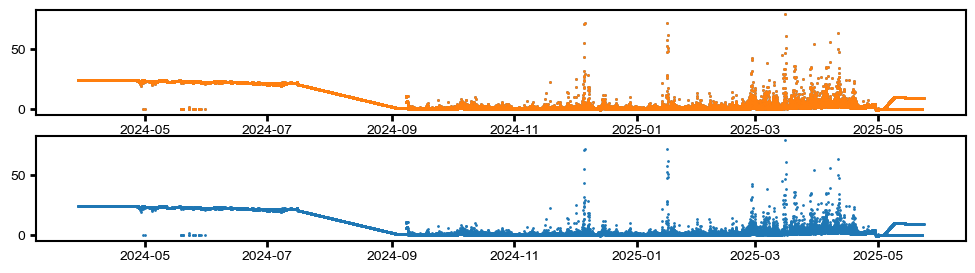

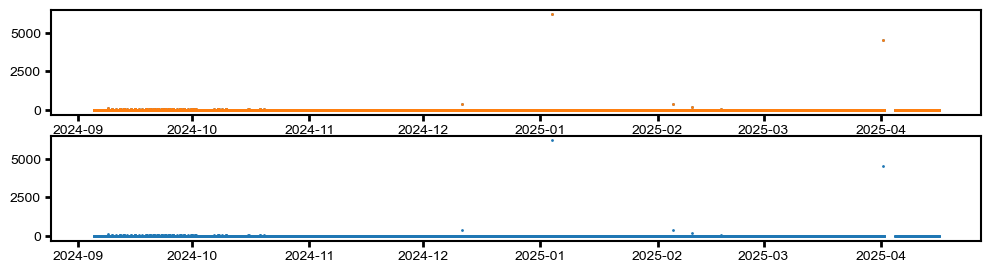

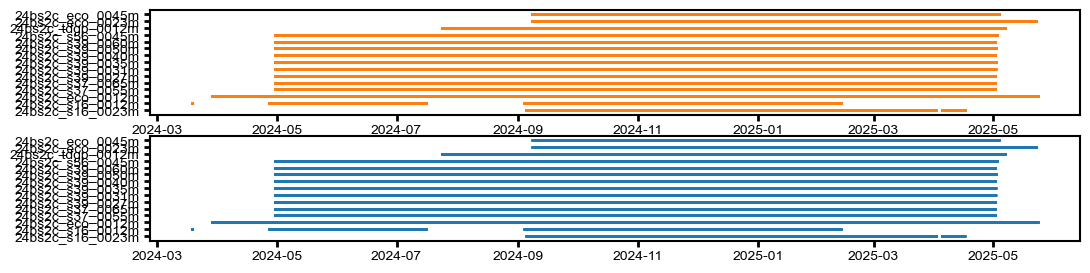

In [18]:
for varname in results_store.columns:
    print(varname)
    fig, ax = plt.subplots(nrows=2,figsize=(12,3))
    ax[0].scatter(orig_results_store['time (UTC)'],orig_results_store[varname],s=1)
    ax[0].scatter(results_store['time (UTC)'],results_store[varname],s=1)
    ax[1].scatter(results_store['time (UTC)'],results_store[varname],s=1)
